# 🏁 Análisis de Telmetría en VW Fun Cup

Este notebook realiza un análisis de clustering sobre los datos de telemetría extráidos de la VW Fun Cup celebrada en el circuito de Spa-Francorchamps.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 📍 Paso 1: Preparación de los Datos
En este paso cargamos el dataset sanetizado de los tres circuitos, eliminamos columnas irrelevantes (como `lapNumber` o identificadores), gestionamos valores nulos, y normalizamos los datos para su posterior análisis con técnicas de clustering.

Pasos específicos:
1. Cargar el dataset.
2. Eliminar columnas no necesarias para el clustering.
3. Filtrar vueltas inválidas (si `lapTime == 0`).
4. Normalizar las variables técnicas (`StandardScaler`).
5. Extraer la columna de 'circuito' para guardar los circuitos como etiquetas para PCA y t-SNE.


In [2]:
import pandas as pd

# Cargar dataset global
df_all_circuits = pd.read_csv("/content/drive/MyDrive/Telemetria-F1-24/all_circuits_sanitized.csv")

# Vista previa de las primeras columnas
print("Columnas iniciales:", df_all_circuits.columns.tolist())
df_all_circuits.head()

Columnas iniciales: ['lapTimeInMS', 'm_frontWing', 'm_rearWing', 'm_onThrottle', 'm_offThrottle', 'm_frontCamber', 'm_rearCamber', 'm_frontToe', 'm_rearToe', 'm_frontSuspension', 'm_rearSuspension', 'm_frontAntiRollBar', 'm_rearAntiRollBar', 'm_frontSuspensionHeight', 'm_rearSuspensionHeight', 'm_brakePressure', 'm_brakeBias', 'm_engineBraking', 'm_rearLeftTyrePressure', 'm_rearRightTyrePressure', 'm_frontLeftTyrePressure', 'm_frontRightTyrePressure', 'm_ballast', 'm_fuelLoad', 'circuit']


,lapTimeInMS,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,m_ballast,m_fuelLoad,circuit
0,73193,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
1,73424,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
2,73167,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
3,73350,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
4,73020,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona


In [3]:
# Filtrar filas con tiempo de vuelta válido
df_all_circuits = df_all_circuits[df_all_circuits["lapTimeInMS"] > 0]

# Eliminar columnas irrelevantes
columns_to_drop = ['lapNumber', 'm_ballast', 'm_fuelLoad']
df_all_circuits = df_all_circuits.drop(columns=columns_to_drop, errors='ignore')

# Eliminar columnas completamente vacías
df_all_circuits = df_all_circuits.dropna(axis=1, how='all')

# Eliminar filas con valores nulos
df_all_circuits = df_all_circuits.dropna()

# Eliminar vueltas duplicadas (setup + tiempo idéntico)
df_all_circuits = df_all_circuits.drop_duplicates()

# Separar tiempos por vuelta y entradas
lap_times = df_all_circuits["lapTimeInMS"]
X_raw = df_all_circuits.drop(columns=["lapTimeInMS"])

In [4]:
# Extraer la columna del circuito y guardarla aparte
circuit_labels = X_raw["circuit"]
X_raw_numeric = X_raw.drop(columns=["circuit"])  # Solo dejamos variables numéricas

# Confirmar que solo quedan numéricas
assert all(pd.api.types.is_numeric_dtype(X_raw_numeric[col]) for col in X_raw_numeric.columns)

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw_numeric)

print(f"Dataset limpio y normalizado. Dimensiones finales: {X_scaled.shape}")
df_all_circuits.head()

Dataset limpio y normalizado. Dimensiones finales: (342, 21)


,lapTimeInMS,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,circuit
0,73193,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,21,54,100,50,100,26.5,26.5,29.5,29.5,barcelona
1,73424,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,21,54,100,50,100,26.5,26.5,29.5,29.5,barcelona
2,73167,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,21,54,100,50,100,26.5,26.5,29.5,29.5,barcelona
3,73350,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,21,54,100,50,100,26.5,26.5,29.5,29.5,barcelona
4,73020,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,21,54,100,50,100,26.5,26.5,29.5,29.5,barcelona


# ✳️ Paso 2: Reducción de Dimensionalidad

Para visualizar la distribución de los setups en el espacio latente, aplicaremos:

1. **PCA (Análisis de Componentes Principales)** para una reducción lineal.
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)** para una reducción no lineal, ideal para detectar estructuras complejas.

Ambos métodos nos ayudarán a inspeccionar visualmente si existe alguna agrupación natural entre los setups.

### Visualización con PCA

Calculamos la varianza por componente. Seleccionamos aquel número de componentes que supere el umbral del 80% ya que nos indica que no supondrá una gran pérdida de información.

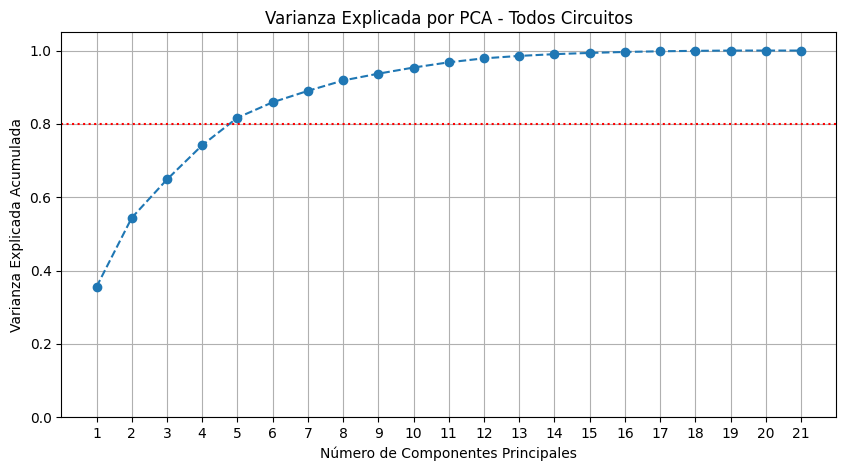

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Ajustar PCA conservando todos los componentes
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza explicada por componente
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Gráfico de varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA - Todos Circuitos')
plt.grid(True)
plt.xticks(range(1, len(explained_var) + 1))
plt.ylim(0, 1.05)
plt.axhline(y=0.8, color='r', linestyle=':')  # umbral típico del 80%
plt.show()

Gráfica con los 5 componentes.

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para visualización 3D

# Aplicar PCA con 5 componentes
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

In [8]:
import pandas as pd
import plotly.express as px

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(5)])
df_pca["lapTime"] = lap_times.values

fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="lapTime",
                    color_continuous_scale="Viridis",
                    title="PCA 3D - Análisis Conjunto (color: Tiempo por vuelta)",
                    labels={"lapTime": "lapTime (ms)"})

fig.show()

In [9]:
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(5)])
df_pca["lapTime"] = lap_times.values

fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="PC4",
                    color_continuous_scale="Viridis",
                    title="PCA 3D - Análisis Conjunto (color: PC4)")

fig.show()

In [10]:
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(5)])
df_pca["lapTime"] = lap_times.values

fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="PC5",
                    color_continuous_scale="Viridis",
                    title="PCA 3D - Análisis Conjunto (color: PC5)")

fig.show()

Visualizamos todas las combinaciones posibles entre 5 componentes (PC1 vs PC2, PC1 vs PC3, etc.).

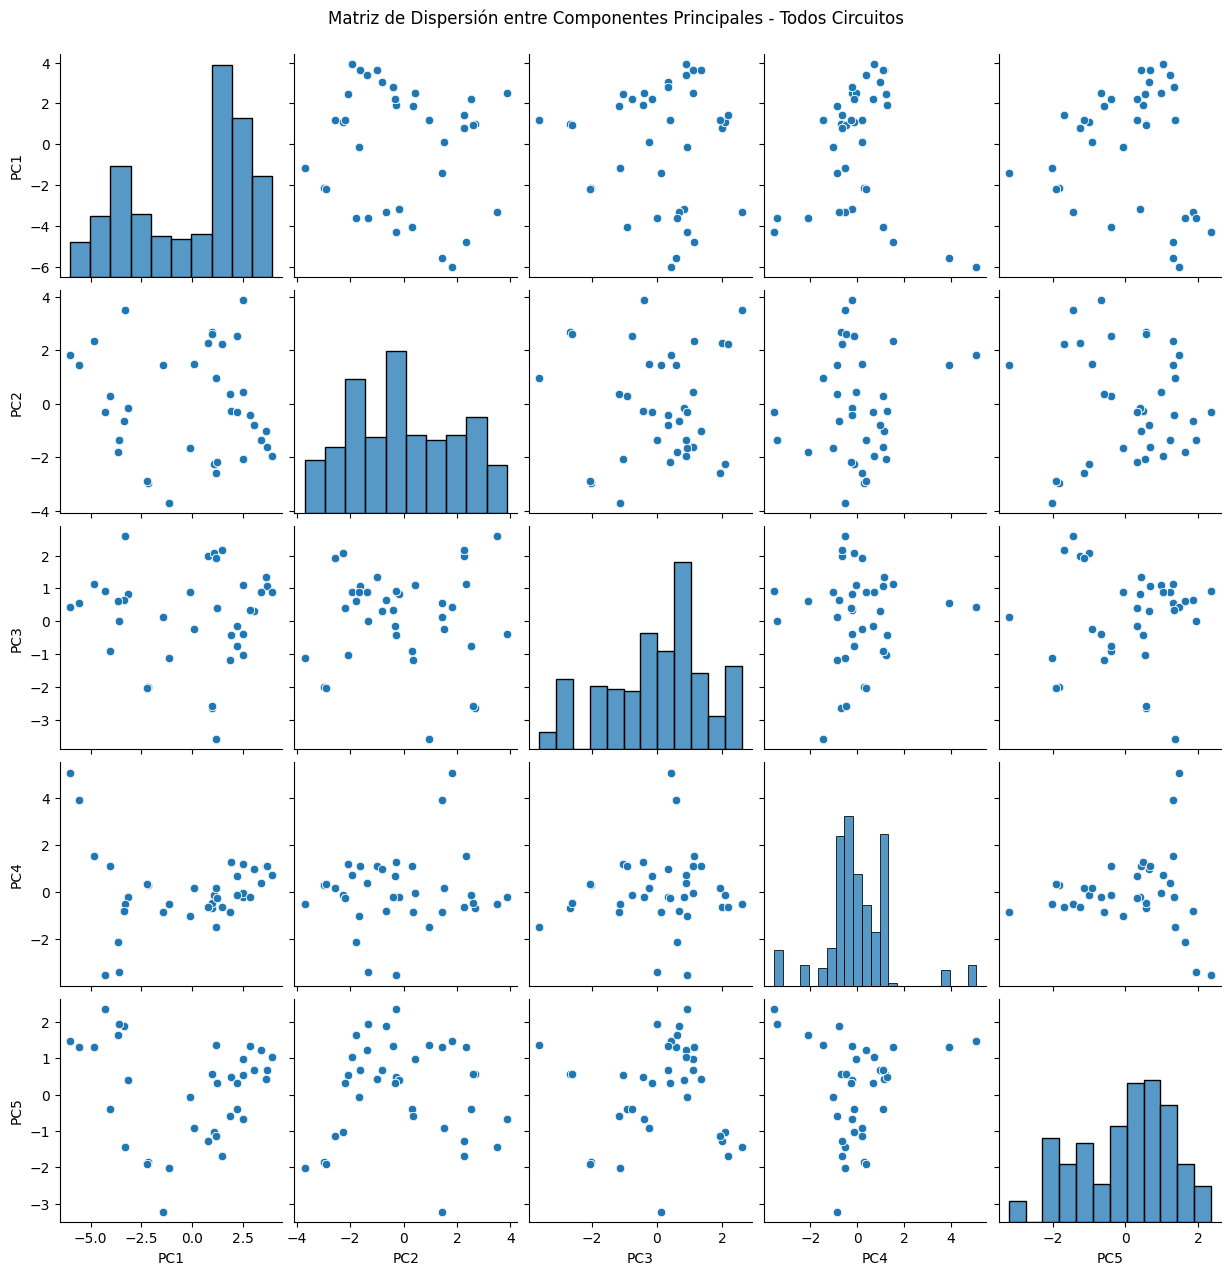

In [11]:
import pandas as pd
import seaborn as sns

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
sns.pairplot(df_pca)
plt.suptitle("Matriz de Dispersión entre Componentes Principales - Todos Circuitos", y=1.02)
plt.show()

Gráfico de barras con la contribución de cada variable para cada uno de los dos componentes.

,PC1,PC2,PC3,PC4,PC5
m_rearLeftTyrePressure,0.312318,0.115905,-0.155683,0.077487,0.228345
m_rearRightTyrePressure,0.312318,0.115905,-0.155683,0.077487,0.228345
m_frontLeftTyrePressure,0.306541,0.132251,-0.167554,0.104879,0.204014
m_frontRightTyrePressure,0.305751,0.130391,-0.166720,0.104249,0.205941
m_frontSuspension,0.291013,-0.068146,0.044929,-0.231373,-0.330977
m_engineBraking,0.279030,0.201262,0.049721,0.059515,0.049823
m_onThrottle,0.230943,-0.075796,0.291644,0.296707,0.077338
m_rearAntiRollBar,0.228273,0.037952,0.452913,-0.057556,0.109439
m_frontAntiRollBar,0.178270,0.108639,0.513722,-0.077301,0.082220
m_frontWing,0.131619,-0.349813,0.023942,-0.306354,0.186984


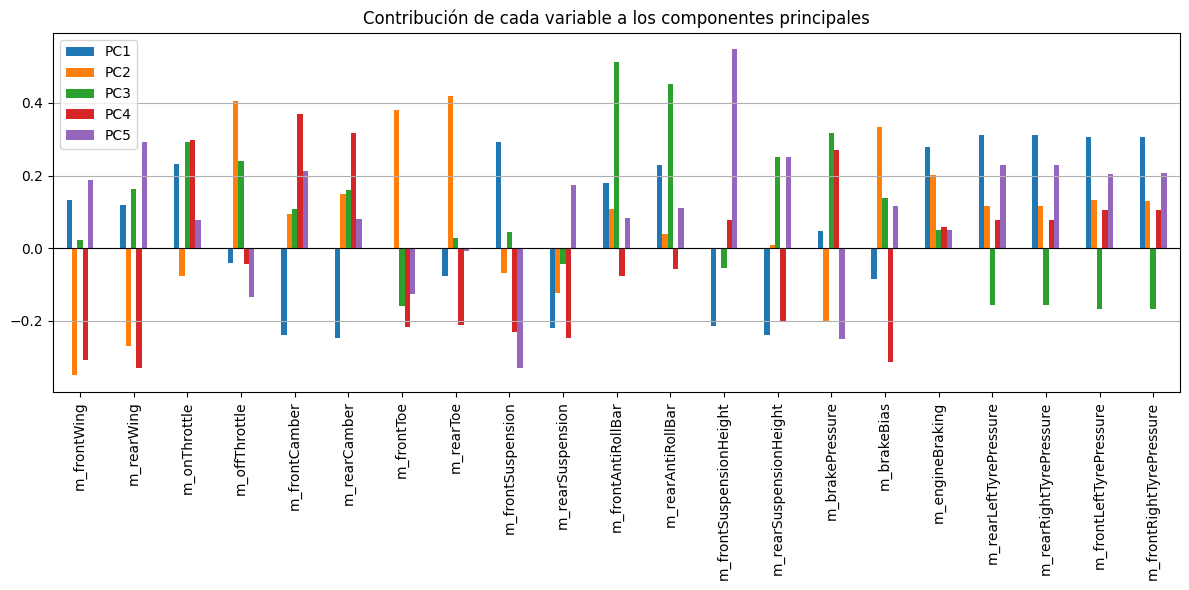

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los nombres de las variables originales
feature_names = X_raw_numeric.columns

# Obtener los loadings (coeficientes de cada variable en cada componente)
loadings = pd.DataFrame(pca.components_.T, index=feature_names,
                        columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Mostrar en tabla ordenada por importancia en PC1
display(loadings.sort_values(by='PC1', ascending=False))

# Visualización en gráfico de barras
loadings.plot(kind='bar', figsize=(12, 6))
plt.title("Contribución de cada variable a los componentes principales")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Top 5 contribuciones positivas/negativas por cada uno de los dos componentes.


Top 5 contribuciones positivas en PC1:
m_rearLeftTyrePressure      0.312318
m_rearRightTyrePressure     0.312318
m_frontLeftTyrePressure     0.306541
m_frontRightTyrePressure    0.305751
m_frontSuspension           0.291013
Name: PC1, dtype: float64

Top 5 contribuciones negativas en PC1:
m_rearCamber              -0.246434
m_frontCamber             -0.238956
m_rearSuspensionHeight    -0.238456
m_rearSuspension          -0.219241
m_frontSuspensionHeight   -0.215362
Name: PC1, dtype: float64


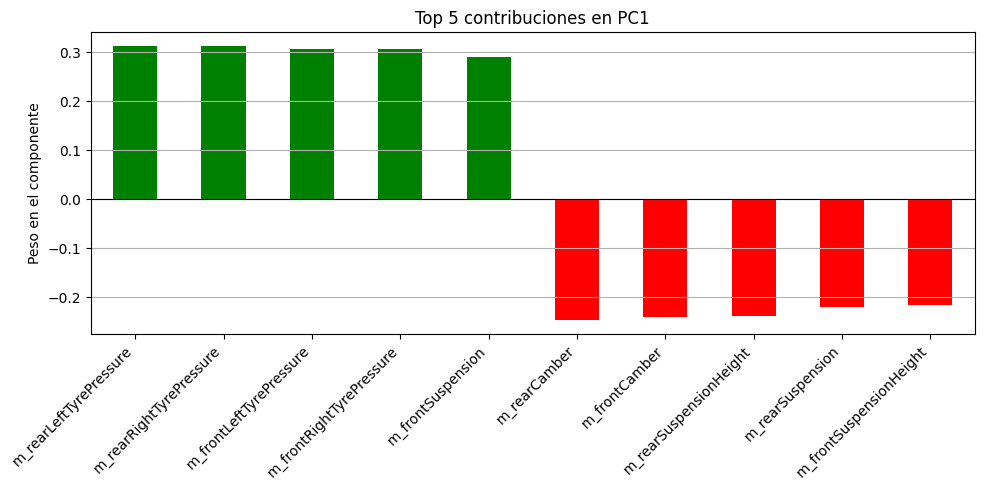


Top 5 contribuciones positivas en PC2:
m_rearToe          0.417678
m_offThrottle      0.405331
m_frontToe         0.379529
m_brakeBias        0.333456
m_engineBraking    0.201262
Name: PC2, dtype: float64

Top 5 contribuciones negativas en PC2:
m_frontWing        -0.349813
m_rearWing         -0.267711
m_brakePressure    -0.200015
m_rearSuspension   -0.122113
m_onThrottle       -0.075796
Name: PC2, dtype: float64


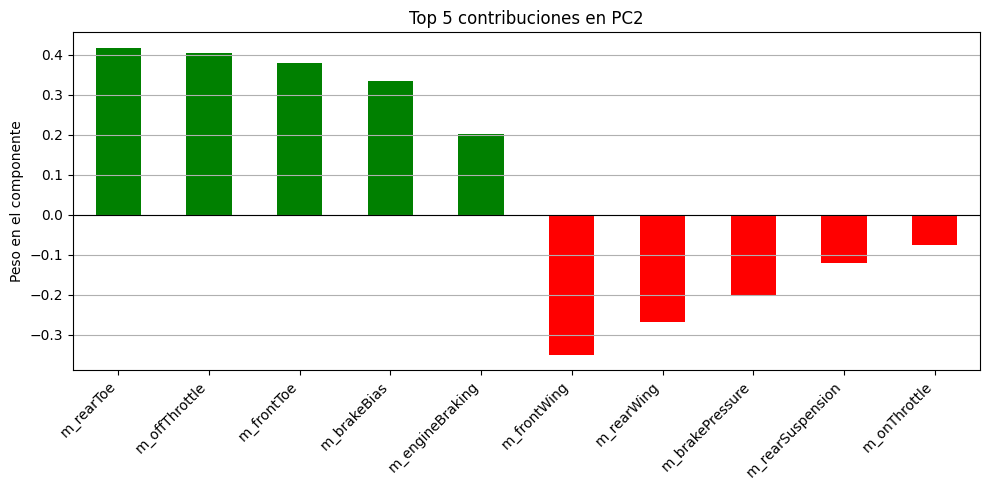


Top 5 contribuciones positivas en PC3:
m_frontAntiRollBar        0.513722
m_rearAntiRollBar         0.452913
m_brakePressure           0.317810
m_onThrottle              0.291644
m_rearSuspensionHeight    0.251172
Name: PC3, dtype: float64

Top 5 contribuciones negativas en PC3:
m_frontLeftTyrePressure    -0.167554
m_frontRightTyrePressure   -0.166720
m_frontToe                 -0.159323
m_rearRightTyrePressure    -0.155683
m_rearLeftTyrePressure     -0.155683
Name: PC3, dtype: float64


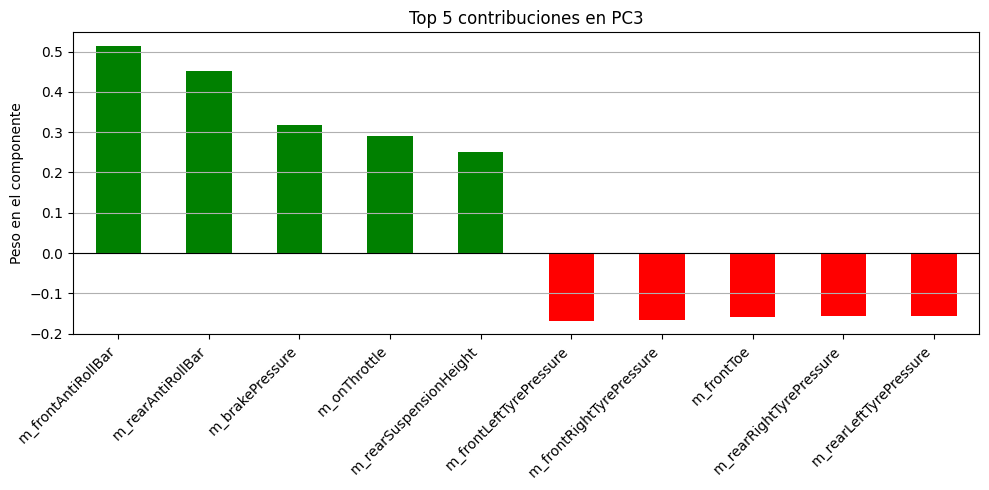


Top 5 contribuciones positivas en PC4:
m_frontCamber              0.369507
m_rearCamber               0.318389
m_onThrottle               0.296707
m_brakePressure            0.269146
m_frontLeftTyrePressure    0.104879
Name: PC4, dtype: float64

Top 5 contribuciones negativas en PC4:
m_rearWing          -0.329581
m_brakeBias         -0.311765
m_frontWing         -0.306354
m_rearSuspension    -0.245757
m_frontSuspension   -0.231373
Name: PC4, dtype: float64


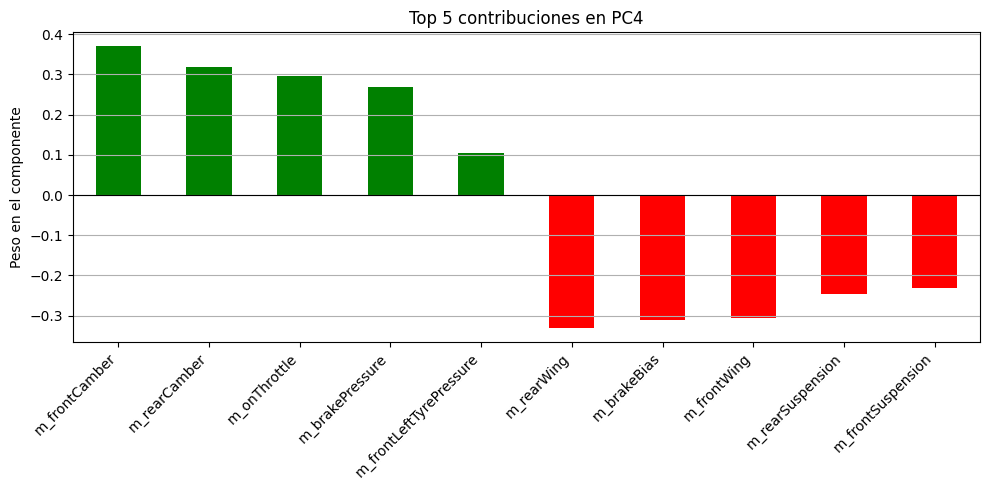


Top 5 contribuciones positivas en PC5:
m_frontSuspensionHeight    0.547786
m_rearWing                 0.290975
m_rearSuspensionHeight     0.250378
m_rearLeftTyrePressure     0.228345
m_rearRightTyrePressure    0.228345
Name: PC5, dtype: float64

Top 5 contribuciones negativas en PC5:
m_frontSuspension   -0.330977
m_brakePressure     -0.249971
m_offThrottle       -0.134484
m_frontToe          -0.127113
m_rearToe           -0.006698
Name: PC5, dtype: float64


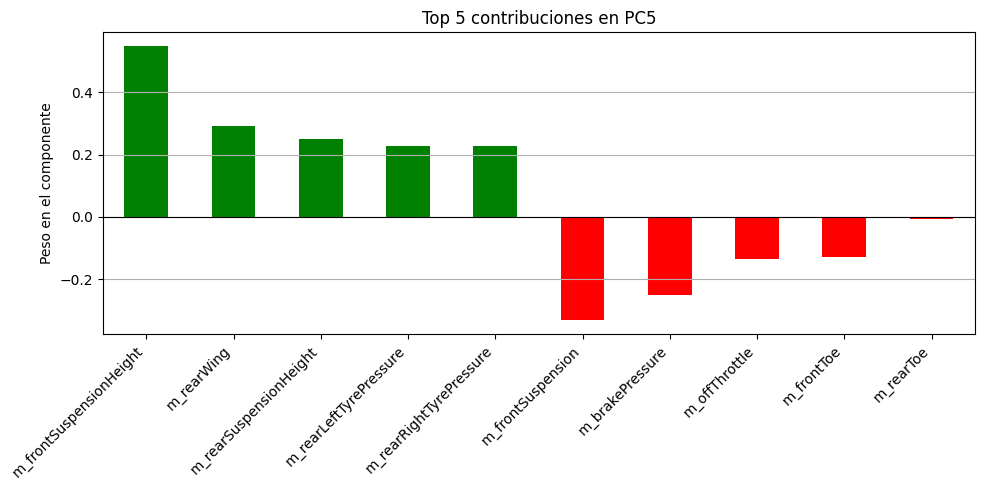

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para mostrar top 5 positivos y negativos de cada componente
def show_top_contributors(loadings, n=5):
    for pc in loadings.columns:
        print(f"\nTop {n} contribuciones positivas en {pc}:")
        print(loadings[pc].sort_values(ascending=False).head(n))

        print(f"\nTop {n} contribuciones negativas en {pc}:")
        print(loadings[pc].sort_values(ascending=True).head(n))

        # Visualización en gráfico de barras
        top_pos = loadings[pc].sort_values(ascending=False).head(n)
        top_neg = loadings[pc].sort_values().head(n)
        top_combined = pd.concat([top_pos, top_neg])

        plt.figure(figsize=(10, 5))
        top_combined.plot(kind='bar',
                          color=['green' if v > 0 else 'red' for v in top_combined])
        plt.title(f'Top {n} contribuciones en {pc}')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.ylabel("Peso en el componente")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

# Ejecutar la función
show_top_contributors(loadings, n=5)

Correlación de cada uno de los componentes con el tiempo de vuelta.

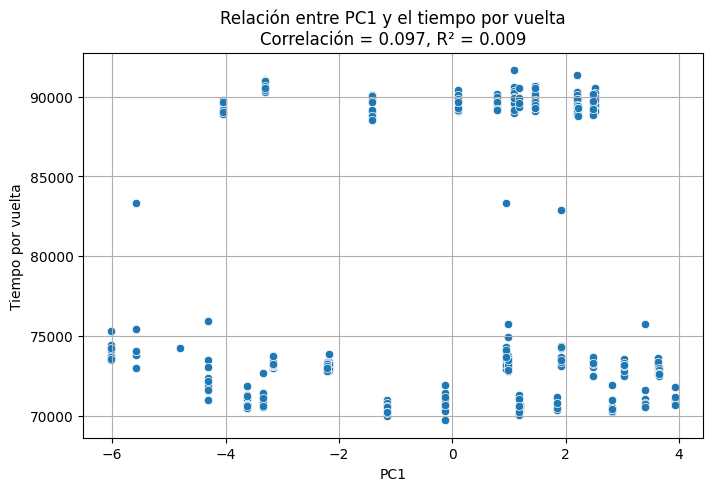

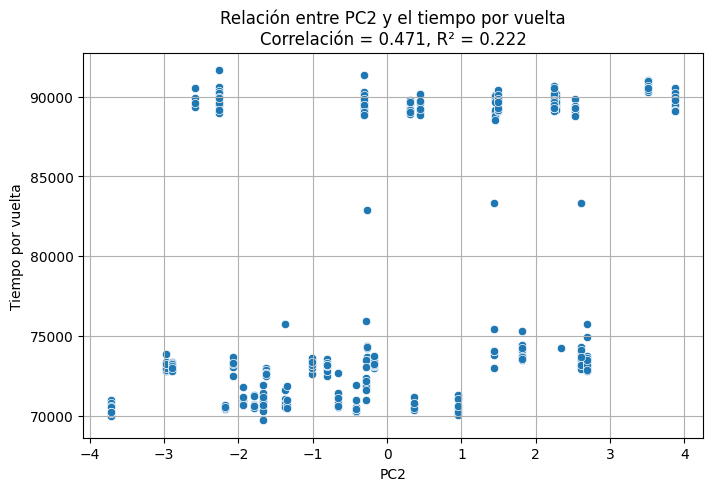

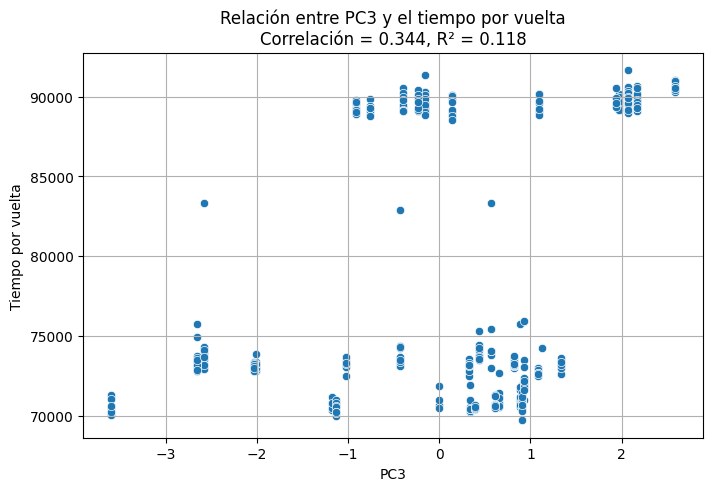

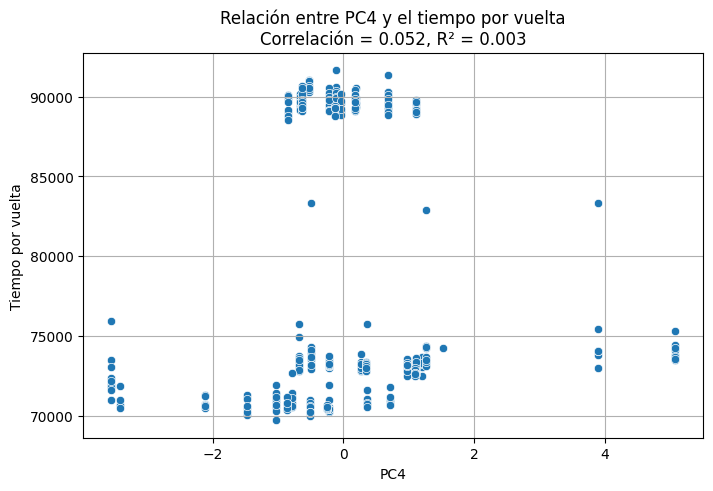

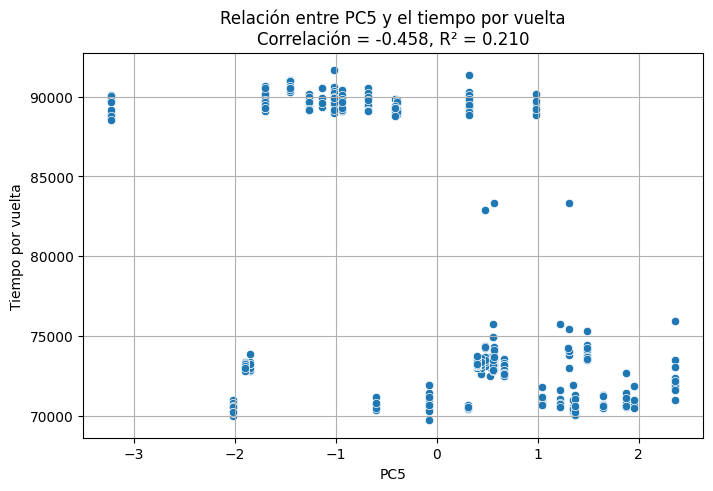

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_pca_vs_lap_time(X_pca, lap_times):
    """
    Analiza la relación entre cada componente principal y el tiempo por vuelta.

    Parámetros:
    - X_pca: array de shape (n_samples, n_components) obtenido de PCA.
    - lap_times: array de tiempos por vuelta (n_samples,).

    Salida:
    - Gráficos de dispersión.
    - Correlaciones de Pearson.
    - Coeficientes de determinación R² para cada componente.
    """
    n_components = X_pca.shape[1]

    for i in range(n_components):
        pc = X_pca[:, i]
        corr = np.corrcoef(pc, lap_times)[0, 1]

        # Regresión lineal simple
        reg = LinearRegression().fit(pc.reshape(-1, 1), lap_times)
        r2 = r2_score(lap_times, reg.predict(pc.reshape(-1, 1)))

        # Gráfico
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=pc, y=lap_times)
        plt.xlabel(f'PC{i+1}')
        plt.ylabel('Tiempo por vuelta')
        plt.title(f'Relación entre PC{i+1} y el tiempo por vuelta\nCorrelación = {corr:.3f}, R² = {r2:.3f}')
        plt.grid(True)
        plt.show()

analyze_pca_vs_lap_time(X_pca, lap_times)

### Visualización con t-SNE

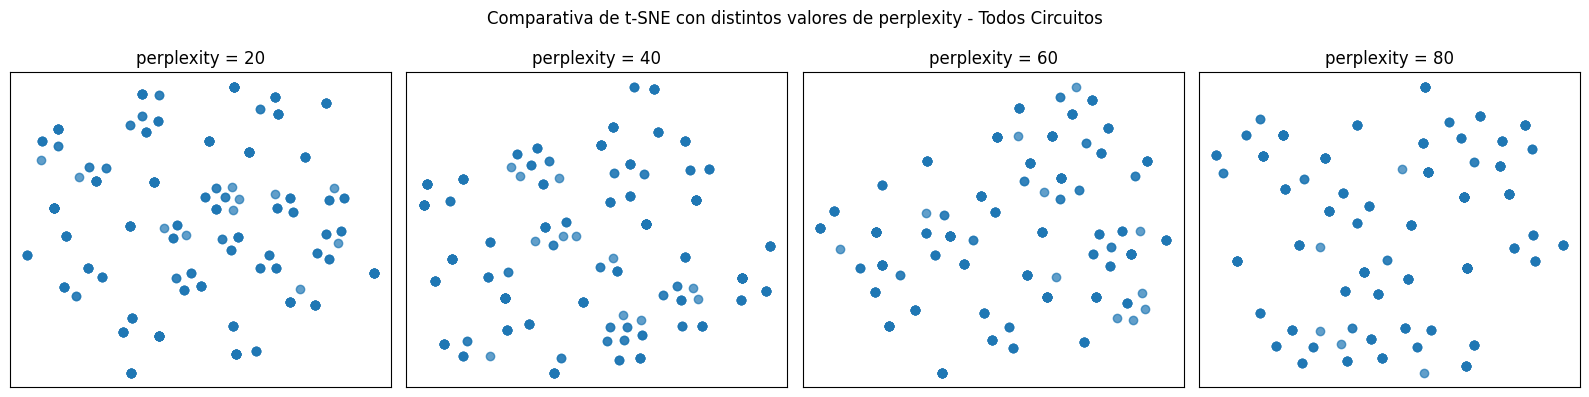

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Valores de perplexity a probar
perplexities = [20, 40, 60, 80]

fig, axs = plt.subplots(1, len(perplexities), figsize=(16, 4))
fig.suptitle("Comparativa de t-SNE con distintos valores de perplexity - Todos Circuitos")

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=500, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    axs[i].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
    axs[i].set_title(f"perplexity = {perp}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

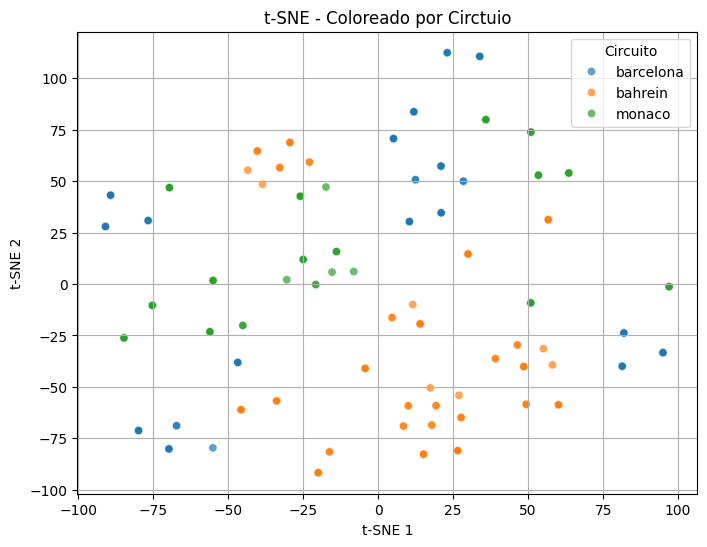

In [16]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=40, max_iter=500, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualización t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=circuit_labels, palette='tab10', alpha=0.7)
plt.title("t-SNE - Coloreado por Circtuio")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Circuito")
plt.grid(True)
plt.show()

# 🧩 Paso 3: Clustering con K-Means + Silhouette Score

En este paso buscamos identificar agrupaciones naturales (clusters) en los setups de todos los circuitos usando K-Means.

Pasos:
1. Calcular el Silhouette Score para valores de K entre 2 y 25.
2. Elegir el mejor K.
3. Analizar la distribución de circuitos por cluster
4. Visualizar los clusters con las proyecciones obtenidas por PCA y t-SNE.

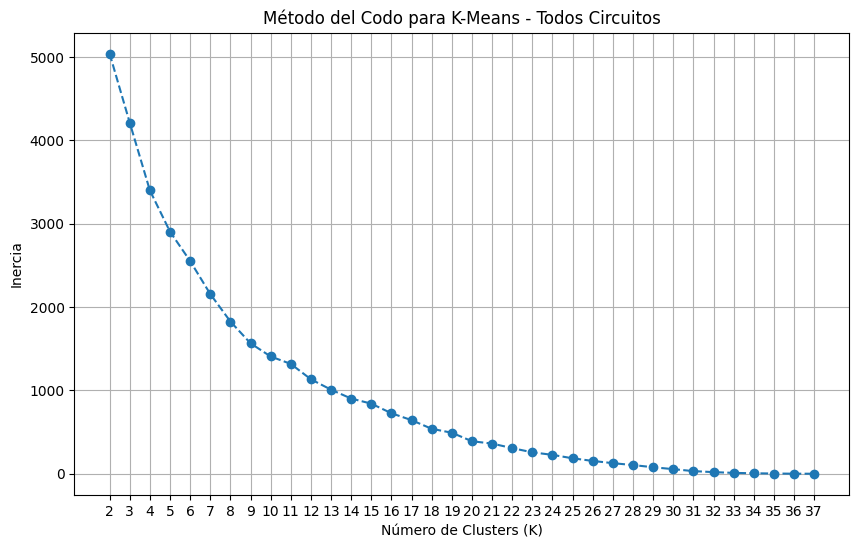

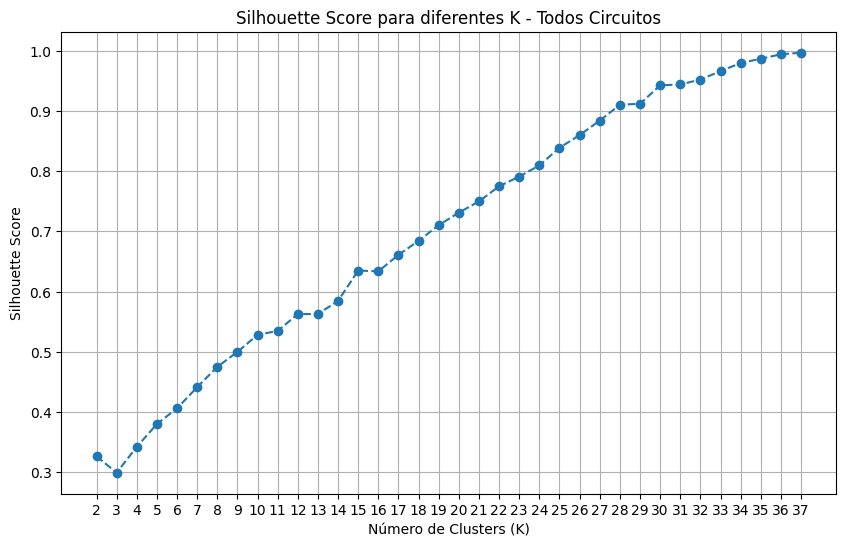

Silhouette Scores: [np.float64(0.3259988387720643), np.float64(0.29872029258158533), np.float64(0.34171883113056917), np.float64(0.37971474040593006), np.float64(0.40576802899934505), np.float64(0.44094761353917833), np.float64(0.4747508208403277), np.float64(0.49960371764376815), np.float64(0.5279496384734501), np.float64(0.5345847016566517), np.float64(0.5624271349223858), np.float64(0.5627078188821191), np.float64(0.5843927533165924), np.float64(0.6348656360858814), np.float64(0.6335799529776798), np.float64(0.6609460417010891), np.float64(0.6842456617684246), np.float64(0.7103377590761836), np.float64(0.7312555867273808), np.float64(0.7498951997545341), np.float64(0.7750143643525124), np.float64(0.7910518641869533), np.float64(0.809755078781628), np.float64(0.8390049573126653), np.float64(0.8600474712876928), np.float64(0.8841957428497654), np.float64(0.9105841360474157), np.float64(0.9121666429985574), np.float64(0.942836670203925), np.float64(0.9442825106080125), np.float64(0.952

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K a probar (de 2 a 37 porque tenemos 37 reglajes en total)
k_range = range(2, 38)
silhouette_scores = []
inertia_scores = [] # Para el método del codo

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Añadir n_init
    kmeans.fit(X_scaled)

    # Calcular Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

    # Guardar inercia para el método del codo
    inertia_scores.append(kmeans.inertia_)

# Gráfico del método del codo (Inercia)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means - Todos Circuitos')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Gráfico de Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes K - Todos Circuitos')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Mostrar los scores para ver numéricamente
print("Silhouette Scores:", silhouette_scores)
print("Inertia Scores:", inertia_scores)

In [18]:
# Elegimos el K donde haya un punto de inflexión
# Entrenamos modelo final
number_of_clusters = 10
kmeans_final = KMeans(n_clusters=number_of_clusters, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X_scaled)

In [19]:
# Análisis de distribución de circuitos por cluster
df_cluster_circuit = pd.DataFrame({
    'cluster': cluster_labels,
    'circuit': circuit_labels
})

crosstab = pd.crosstab(df_cluster_circuit['cluster'], df_cluster_circuit['circuit'])
print("Distribución de circuitos dentro de cada cluster:")
display(crosstab)

Distribución de circuitos dentro de cada cluster:


circuit,bahrein,barcelona,monaco
cluster,,,
0,13,16,11
1,27,47,26
2,19,0,0
3,0,25,8
4,0,14,0
5,14,0,21
6,10,0,0
7,38,0,0
8,0,28,7


## Visualización con PCA

In [20]:
# Crear DataFrame para visualización
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
df_pca["cluster"] = cluster_labels
df_pca["lapTimeInMS"] = lap_times.values

# Gráfico 3D interactivo
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="cluster",  # Colorea por etiqueta de cluster
                    hover_data=["lapTimeInMS"],  # mostrar tiempo en hover
                    title="Clusters con K-Means (PCA 3D) - Todos Circuitos")

fig.update_layout(scene=dict(
    xaxis_title="Componente principal 1",
    yaxis_title="Componente principal 2",
    zaxis_title="Componente principal 3"
))

fig.show()

## Visualización con t-SNE

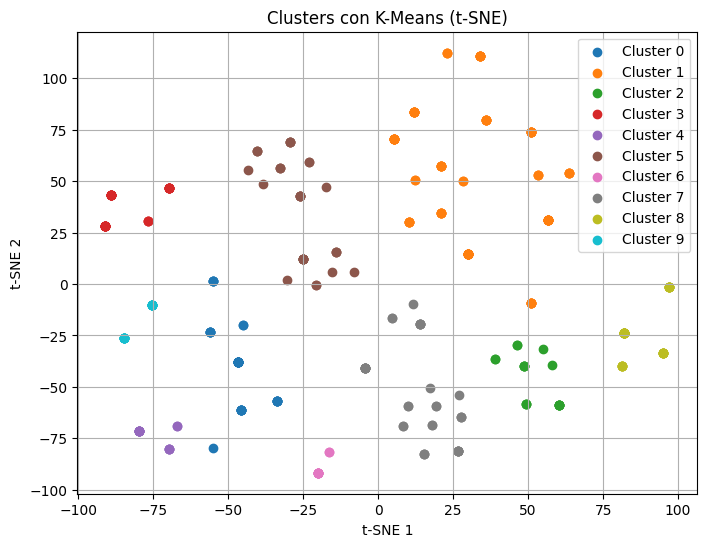

In [21]:
plt.figure(figsize=(8, 6))
for i in range(number_of_clusters):
    plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1],
                label=f'Cluster {i}')
plt.title("Clusters con K-Means (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides con K-means

In [22]:
import pandas as pd

# Reconstruir los setups escalados a su forma original
X_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled),
                          columns=X_raw_numeric.columns)

# Añadir etiquetas de clúster y tiempo de vuelta original
X_unscaled["cluster"] = cluster_labels
X_unscaled["lapTime"] = lap_times.values

# Agrupar por clúster y calcular centroides (media de setups) y tiempo medio
centroids_df = X_unscaled.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio de vuelta (opcional, para interpretación posterior)
centroids_df = centroids_df.sort_values(by="lapTime").reset_index(drop=True)

centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,9,50.000000,50.000000,19.444444,41.111111,-3.400000,-2.200000,0.100000,0.250,25.000000,...,32.000000,78.555556,98.333333,55.222222,40.000000,20.500000,20.500000,22.700001,22.700001,71745.777778
1,3,45.848485,34.030303,22.575758,20.000000,-3.500000,-2.200000,0.000000,0.000,37.212121,...,22.272727,55.757576,100.000000,50.757576,15.151515,20.924242,20.924242,23.924242,23.924242,72447.000000
2,8,41.314286,34.000000,31.000000,41.000000,-3.500000,-2.200000,0.232857,0.250,35.000000,...,25.000000,55.000000,95.000000,55.000000,100.000000,26.500000,26.500000,29.500000,29.500000,73214.171429
3,4,27.714286,21.857143,62.142857,52.857143,-2.785714,-1.542857,0.055714,0.200,6.285714,...,34.000000,66.000000,100.000000,52.857143,55.714286,20.871429,20.871429,23.114286,23.114286,74726.000000
4,1,46.500000,42.210000,79.400000,37.600000,-3.500000,-2.200000,0.015000,0.057,40.200000,...,23.050000,55.320000,100.000000,52.390000,89.700000,26.440000,26.440000,29.470000,29.470000,77132.380000


## Exportado de centroides con K-means

In [23]:
# Exportamos los centroides para usarlos en el sistema recomendador
centroids_df.to_csv("all_circuits_kmeans_centroids.csv", index=False)
print("Centroides exportados correctamente a 'all_circuits_kmeans_centroids.csv'")

Centroides exportados correctamente a 'all_circuits_kmeans_centroids.csv'


# ⚙️ Paso 4: Clustering con DBSCAN

Utilizaremos el algoritmo DBSCAN para encontrar agrupaciones sin necesidad de definir el número de clusters.

Pasos:
1. Ajustar el modelo DBSCAN sobre los datos normalizados.
2. Analizar la distribución de circuitos por cluster.
3. Visualizar los clusters con PCA y t-SNE.
4. Calcular los centroides descartando el ruido (`cluster = -1`).
5. Exportar los centroides para el sistema recomendador.

Agrupar reglajes únicos y persistir el tiempo más rápido.

In [24]:
# Unir X_raw y lap_times en un único DataFrame
df_full = X_raw.copy()
df_full["lapTime"] = lap_times.values

# Agrupar por combinaciones únicas de reglajes y calcular la media de tiempos
df_grouped = df_full.groupby(list(X_raw.columns)).agg({
    "lapTime": "min"
}).reset_index()

Estandarizar reglajes únicos.

In [25]:
from sklearn.preprocessing import StandardScaler

X_unique = df_grouped.drop(columns=["lapTime", "circuit"])
y_unique = df_grouped["lapTime"]

scaler = StandardScaler()
X_scaled_unique = scaler.fit_transform(X_unique)

Determinamos eps con la curva k-distance.

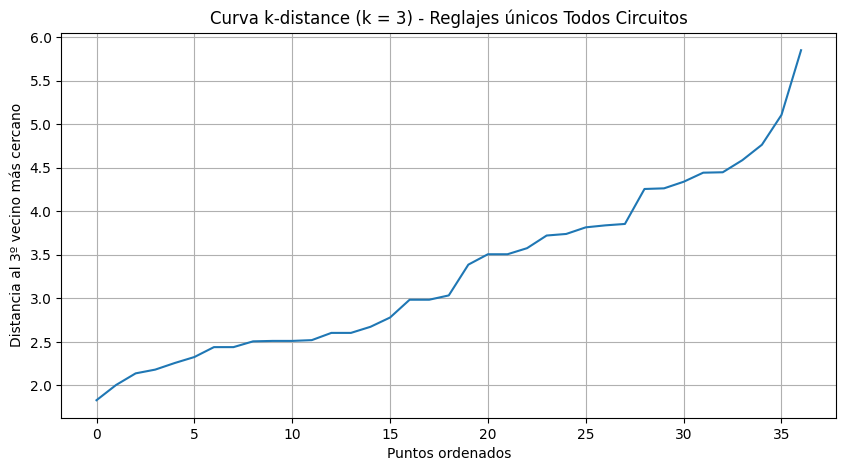

In [26]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 3  # ajustar de 3 a 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled_unique)
distances, indices = neighbors_fit.kneighbors(X_scaled_unique)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'Curva k-distance (k = {min_samples}) - Reglajes únicos Todos Circuitos')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {min_samples}º vecino más cercano')
plt.grid(True)
plt.show()

In [27]:
from sklearn.cluster import DBSCAN

# Estimar eps visualmente desde la curva anterior
eps = 3.0  # lo ajustamos en función de la gráfica
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_scaled_unique)

# Añadir los resultados al DataFrame agrupado
df_grouped["cluster"] = db_labels

# Contar etiquetas encontradas
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"🔍 DBSCAN encontró {n_clusters_db} clusters y {n_noise} puntos de ruido.")

🔍 DBSCAN encontró 5 clusters y 15 puntos de ruido.


In [28]:
# Extraer los circuitos asociados a los setups únicos (ya agrupados)
circuit_labels_unique = df_grouped["circuit"].values  # debe tener longitud 37

# Crear el DataFrame para análisis de distribución
df_cluster_circuit = pd.DataFrame({
    'cluster': db_labels,
    'circuit': circuit_labels_unique
})

# Tabla cruzada
crosstab = pd.crosstab(df_cluster_circuit['cluster'], df_cluster_circuit['circuit'])
print("Distribución de circuitos dentro de cada cluster:")
display(crosstab)

Distribución de circuitos dentro de cada cluster:


circuit,bahrein,barcelona,monaco
cluster,,,
-1,5,4,6
0,2,2,0
1,2,4,3
2,1,1,1
3,0,2,1
4,2,0,1


## Visualización con PCA

In [29]:
from sklearn.decomposition import PCA
import plotly.express as px

X_pca_dbscan = pca.fit_transform(X_scaled_unique)

df_grouped[["PC1", "PC2", "PC3", "PC4", "PC5"]] = X_pca_dbscan

fig = px.scatter_3d(df_grouped, x="PC1", y="PC2", z="PC3",
                    color="cluster",
                    hover_data=["lapTime"],
                    title="Clusters DBSCAN (PCA 3D) - Todos Circuitos")
fig.show()

## Visualización con t-SNE

In [30]:
tsne = TSNE(n_components=2, perplexity=2, max_iter=1000, random_state=42)
X_tsne_dbscan = tsne.fit_transform(X_scaled_unique)

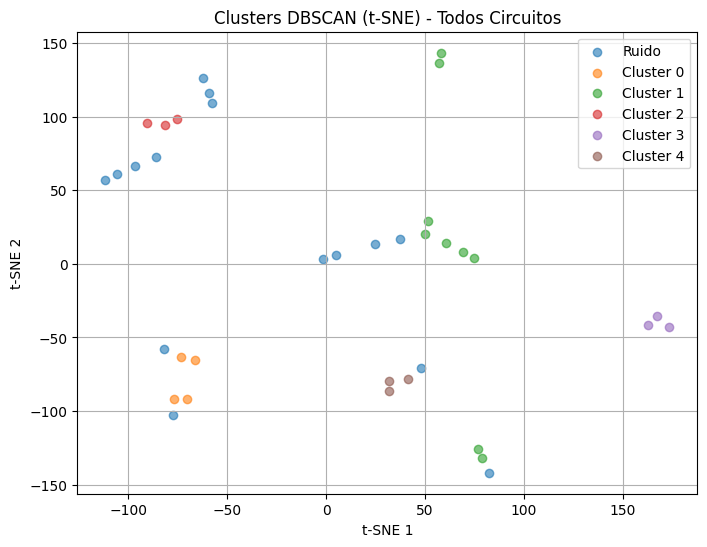

In [31]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_member_mask = (db_labels == k)
    label = "Ruido" if k == -1 else f"Cluster {k}"
    plt.scatter(X_tsne_dbscan[class_member_mask, 0], X_tsne_dbscan[class_member_mask, 1],
                label=label, alpha=0.6)

plt.title("Clusters DBSCAN (t-SNE) - Todos Circuitos")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides (sin ruido)

In [32]:
# Reconstrucción de los reglajes originales desde los datos únicos
X_db_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled_unique),
                             columns=X_raw_numeric.columns)  # usar las columnas originales de reglajes

# Añadir etiquetas de cluster y tiempos mínimos
X_db_unscaled["cluster"] = db_labels  # obtenidos de DBSCAN
X_db_unscaled["lapTime"] = y_unique.values  # mejores tiempos por reglaje

# Filtrar los puntos que no son ruido
X_db_filtered = X_db_unscaled[X_db_unscaled["cluster"] != -1]

# Calcular centroides de cada cluster y tiempo medio por vuelta
db_centroids_df = X_db_filtered.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio (el más bajo primero)
db_centroids_df = db_centroids_df.sort_values(by="lapTime").reset_index(drop=True)

# Mostrar primeros centroides
db_centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,3,46.333333,35.333333,21.666667,20.000000,-3.5,-2.200000,0.0000,0.00,37.666667,...,22.000000,55.666667,100.0,50.666667,13.333333,20.933333,20.933333,23.933333,23.933333,71837.666667
1,1,47.777778,42.333333,81.666667,35.555556,-3.5,-2.200000,0.0000,0.05,40.111111,...,23.444444,54.888889,100.0,52.666667,90.000000,26.500000,26.500000,29.500000,29.500000,75532.222222
2,2,41.666667,38.333333,41.666667,48.333333,-3.2,-1.833333,0.1000,0.09,27.333333,...,26.666667,64.333333,97.0,54.000000,30.000000,21.133333,21.133333,23.766666,23.766666,77461.666667
3,0,37.000000,31.000000,48.750000,55.000000,-3.5,-2.200000,0.2375,0.25,37.250000,...,22.500000,53.750000,95.5,54.500000,100.000000,26.500000,26.500000,29.500000,29.500000,80891.250000
4,4,50.000000,48.000000,100.000000,26.666667,-3.5,-2.200000,0.0000,0.00,40.000000,...,20.666667,59.666667,99.0,52.333333,100.000000,22.033333,22.033333,24.400000,24.400000,82910.000000


## Exportado de centroides con DBSCAN

In [33]:
# Exportar a CSV para uso en recomendador
db_centroids_df.to_csv("all_circuits_dbscan_centroids.csv", index=False)
print("Centroides DBSCAN exportados correctamente a 'all_circuits_dbscan_centroids.csv'")

Centroides DBSCAN exportados correctamente a 'all_circuits_dbscan_centroids.csv'


# 🧐 Paso 5: Intrepretación de Clusters
Después de visualizar los distintos cluster usando algoritmos de clustering (K-means y DBSCAN), vamos a identificar cuál es el cluster donde el tiempo por vuelta es más rápido. Para ello, tomaremos los tiempos por vuelta de cada cluster y haremos la media de ellos, viendo así cuál es el tiempo por vuelta medio más bajo (la recomendación).

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cluster_performance(cluster_labels, lap_times, X_original, feature_names=None):
    """
    Evalúa el rendimiento por cluster con tiempos de vuelta y devuelve el reglaje medio del mejor cluster.

    Parámetros:
    - cluster_labels: array (n_samples,) con etiquetas de clustering (KMeans, DBSCAN, etc.).
    - lap_times: array (n_samples,) con los tiempos por vuelta.
    - X_original: array o DataFrame con los reglajes sin escalar (shape: n_samples, n_features).
    - feature_names: lista opcional con nombres de las columnas de X_original.

    Retorna:
    - best_cluster: etiqueta del cluster con mejor tiempo medio.
    - average_setup: Series con el reglaje promedio de ese cluster.
    """

    # Crear DataFrame con resultados
    df = pd.DataFrame({
        'cluster': cluster_labels,
        'lap_time': lap_times
    })

    # Agrupación por cluster
    summary = df.groupby('cluster')['lap_time'].agg(['mean', 'std', 'count']).sort_values('mean')

    print("📊 Resumen por cluster (ordenado por mejor tiempo medio):")
    display(summary)

    # Visualización
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='cluster', y='lap_time', data=df)
    plt.title("Distribución del tiempo por vuelta por cluster - Todos Circuitos")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo por vuelta")
    plt.grid(True)
    plt.show()

    # Identificar el mejor cluster
    best_cluster = summary.index[0]
    print(f"🏁 El cluster más rápido para todos circuitos es el #{best_cluster} con tiempo medio de {summary.loc[best_cluster, 'mean']:.3f} s")

    # Cálculo del reglaje promedio de ese cluster
    if isinstance(X_original, pd.DataFrame):
        best_setups = X_original[cluster_labels == best_cluster]
    else:
        best_setups = pd.DataFrame(X_original[cluster_labels == best_cluster],
                                   columns=feature_names)

    average_setup = best_setups.mean()

    print("\n🔧 Reglaje promedio del mejor cluster:")
    display(average_setup)

    return best_cluster, average_setup


## K-means

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
9,71745.777778,1361.512073,18
3,72447.000000,1183.102331,33
8,73214.171429,2181.919332,35
4,74726.000000,2556.627737,14
1,77132.380000,7744.684518,100
0,77887.225000,8029.188762,40
5,78456.914286,9539.420763,35
2,89417.842105,462.390079,19
7,89620.684211,481.414364,38


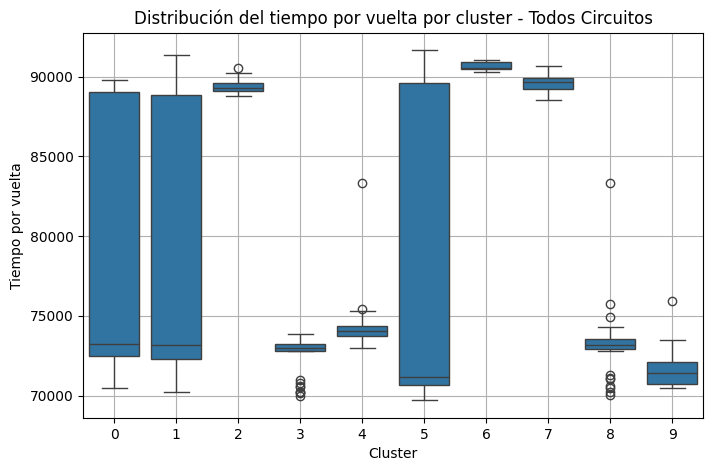

🏁 El cluster más rápido para todos circuitos es el #9 con tiempo medio de 71745.778 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,50.000000
m_rearWing,50.000000
m_onThrottle,19.444444
m_offThrottle,41.111111
m_frontCamber,-3.400000
m_rearCamber,-2.200000
m_frontToe,0.100000
m_rearToe,0.250000
m_frontSuspension,25.000000
m_rearSuspension,24.000000


In [35]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=cluster_labels,
    lap_times=lap_times,
    X_original=X_raw_numeric,  # sin escalar
    feature_names=X_raw_numeric.columns.tolist()
)

## DBSCAN

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
3,71837.666667,1614.851490,3
1,75532.222222,7616.527732,9
-1,77419.866667,8742.261990,15
2,77461.666667,9986.870497,3
0,80891.250000,9267.774324,4
4,82910.000000,10820.490701,3


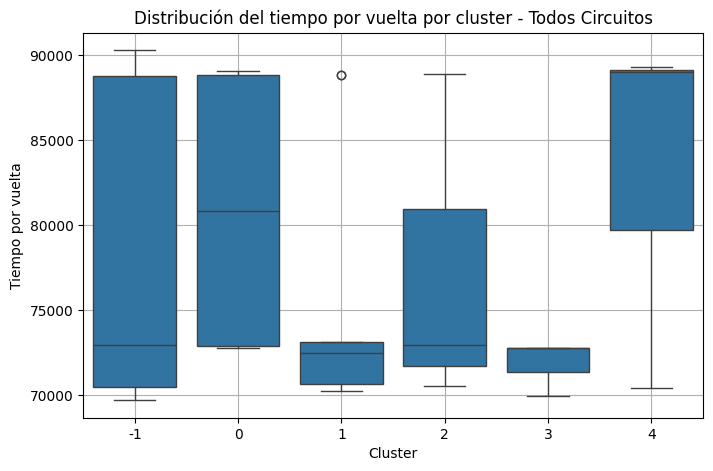

🏁 El cluster más rápido para todos circuitos es el #3 con tiempo medio de 71837.667 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,46.333333
m_rearWing,35.333333
m_onThrottle,21.666667
m_offThrottle,20.000000
m_frontCamber,-3.500000
m_rearCamber,-2.200000
m_frontToe,0.000000
m_rearToe,0.000000
m_frontSuspension,37.666667
m_rearSuspension,9.000000


In [36]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=db_labels,
    lap_times=y_unique,
    X_original=X_unique,
    feature_names=X_unique.columns.tolist()
)

## Clusters Lentos Vs Rápidos
Finalmente, miraremos aquellos clusters cuyos centroides tienen un tiempo por vuelta superior o inferior a la media de todos los tiempos.

In [37]:
from scipy.stats import mode
import matplotlib.pyplot as plt
import numpy as np

def plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean"):
    """
    Dibuja un gráfico de barras para comparar tiempos medios de clusters contra la media o moda global.

    Parámetros:
    - centroids_df: DataFrame con columna 'cluster' y 'lapTime'
    - lap_times: Serie o array con todos los tiempos por vuelta
    - title_suffix: "K-Means" o "DBSCAN"
    - reference: 'mean' o 'mode' (define con qué se comparan los centroides)
    """
    # Selección de umbral de comparación
    if reference == "mean":
        ref_value = lap_times.mean()
        ref_label = f"Media global: {ref_value:.0f} ms"
    elif reference == "median":
        ref_value = lap_times.median()
        ref_label = f"Mediana global: {ref_value:.0f} ms"
    elif reference == "mode":
      ref_result = mode(lap_times, keepdims=True)  # <-- importante porque sino se devuelve un escalar en vez de un array
      ref_value = ref_result.mode[0]
      ref_label = f"Moda global: {ref_value:.0f} ms"
    else:
        raise ValueError("Parámetro 'reference' debe ser 'mean' o 'mode'.")

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.bar(centroids_df["cluster"], centroids_df["lapTime"], color='skyblue', edgecolor='black')

    # Línea horizontal de referencia
    plt.axhline(ref_value, color='red', linestyle='--', label=ref_label)

    # Anotaciones: "Rápido"/"Lento" con respecto al umbral
    for idx, row in centroids_df.iterrows():
        label = "Rápido" if row["lapTime"] < ref_value else "Lento"
        plt.text(row["cluster"], row["lapTime"] + 100, label, ha='center', fontsize=9)

    # Ajuste eje Y
    min_lap = centroids_df["lapTime"].min()
    max_lap = centroids_df["lapTime"].max()
    delta = max_lap - min_lap
    margin = delta * 0.25
    plt.ylim(min_lap - margin, max_lap + margin)

    # Título y estilo
    plt.title(f"Comparación de Clusters: Rápidos vs Lentos ({title_suffix}, ref: {reference}) - Todos Circuitos")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo medio por vuelta (ms)")
    plt.legend()
    plt.grid(True)
    plt.show()

## K-Means

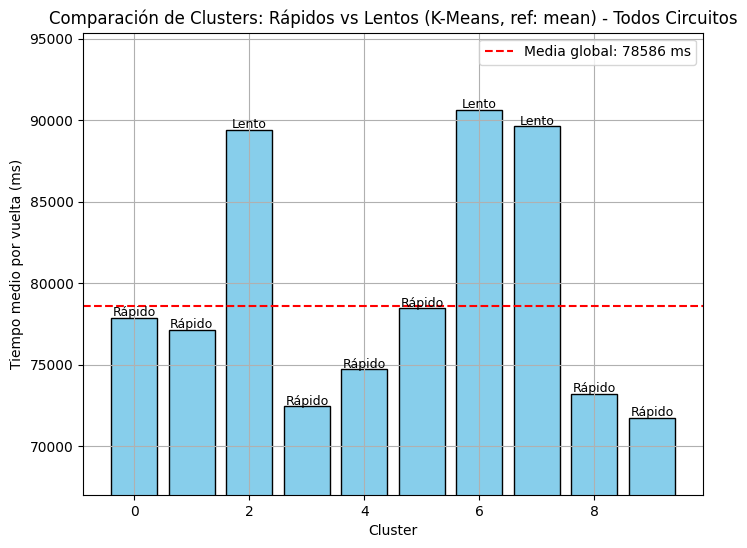

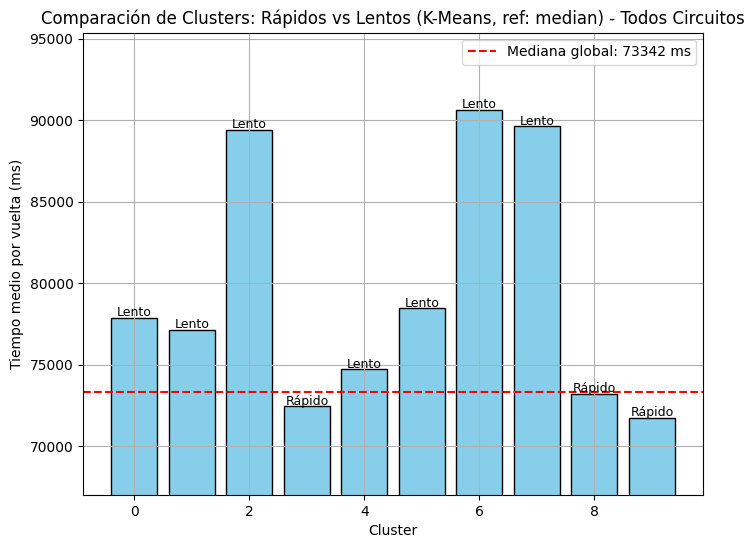

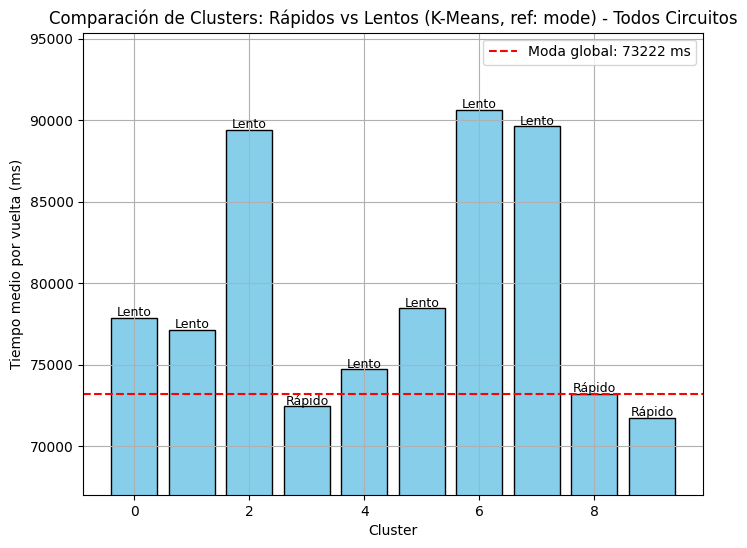

In [38]:
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="median")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mode")

## DBSCAN

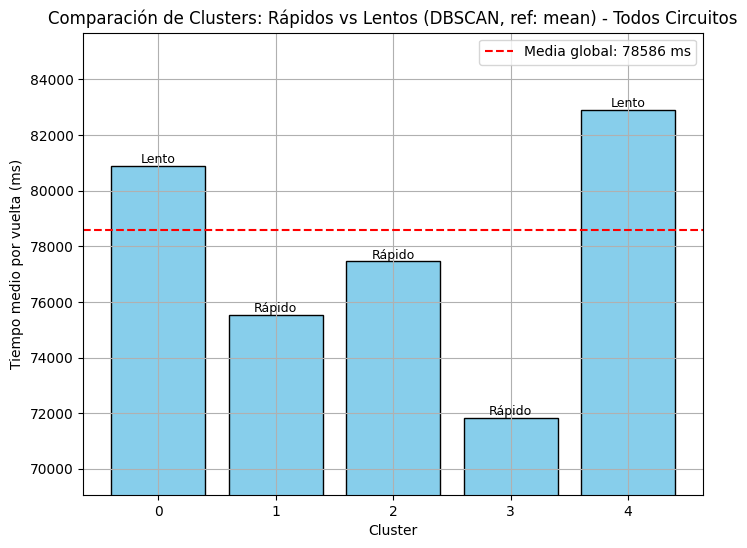

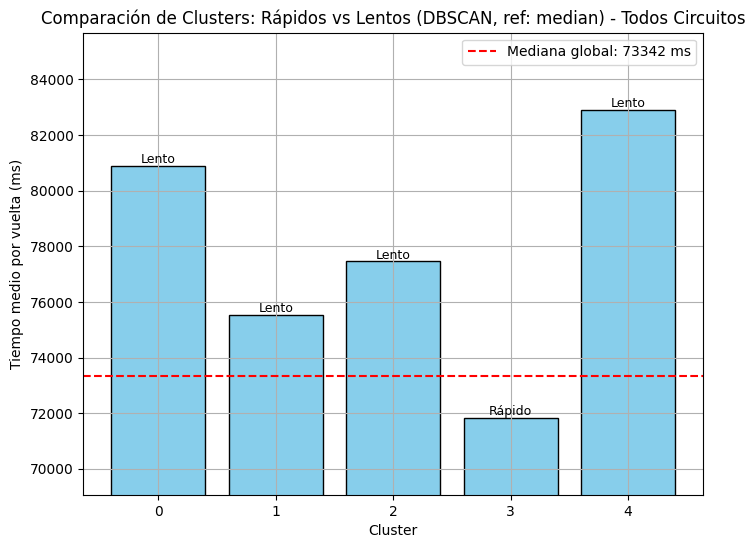

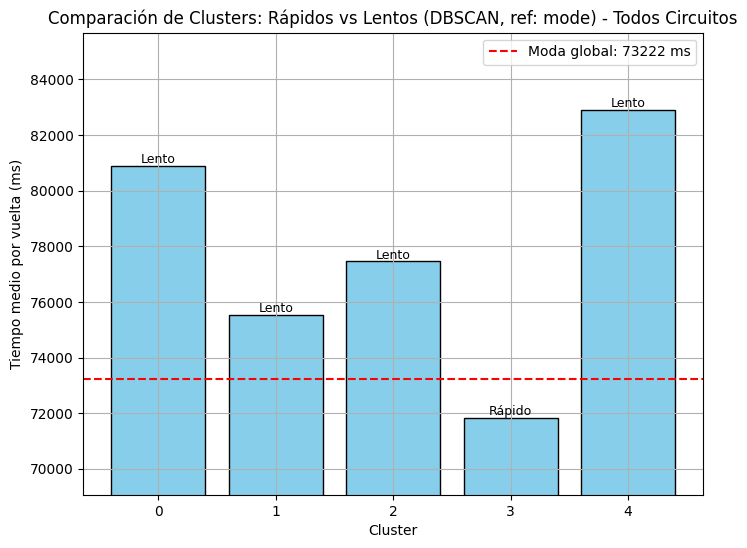

In [39]:
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="mean")
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="median")
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="mode")